In [ ]:
!pip install kaggle

In [ ]:
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import rc
from pylab import rcParams
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

In [ ]:

os.environ['KAGGLE_USERNAME'] = "vishakhaas"
os.environ['KAGGLE_KEY'] = "d6f9f1e38522fc8e86dba775c285da29"

#**DATASET**

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

os.makedirs('data', exist_ok=True)

api = KaggleApi()
api.authenticate()
api.dataset_download_file('saeedaslimanesh/twitter-airline-sentiment', 'Tweets.csv')
zip_file = ZipFile('Tweets.csv.zip')
zip_file.extractall('data')
zip_file.close()
os.remove('Tweets.csv.zip')


Dataset URL: https://www.kaggle.com/datasets/saeedaslimanesh/twitter-airline-sentiment


In [ ]:
df = pd.read_csv('data/Tweets.csv')

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.shape

(14640, 15)

In [ ]:
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
#checking unique values
df.nunique()

,0
tweet_id,14485
airline_sentiment,3
airline_sentiment_confidence,1023
negativereason,10
negativereason_confidence,1410
airline,6
airline_sentiment_gold,3
name,7701
negativereason_gold,13
retweet_count,18


In [ ]:
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df['tweet_created'].min()

datetime.date(2015, 2, 16)

In [ ]:
df['tweet_created'].max()

datetime.date(2015, 2, 24)

In [ ]:
#checking how many days in tweet_created columns
df['tweet_created'].nunique()

9

In [ ]:
numberoftweets = df.groupby('tweet_created').size()

In [ ]:
numberoftweets.dtype

dtype('int64')

In [ ]:
numberoftweets

,0
tweet_created,
2015-02-16,4
2015-02-17,1408
2015-02-18,1344
2015-02-19,1376
2015-02-20,1500
2015-02-21,1557
2015-02-22,3079
2015-02-23,3028
2015-02-24,1344


# **DATA CLEANING**

In [ ]:
df.isna().sum()

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,5462
negativereason_confidence,4118
airline,0
airline_sentiment_gold,14600
name,0
negativereason_gold,14608
retweet_count,0


In [ ]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


,0
tweet_id,0.00
airline_sentiment,0.00
airline_sentiment_confidence,0.00
negativereason,37.31
negativereason_confidence,28.13
airline,0.00
airline_sentiment_gold,99.73
name,0.00
negativereason_gold,99.78
retweet_count,0.00


In [ ]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada)


In [ ]:
freq = df.groupby('negativereason').size()
freq

,0
negativereason,
Bad Flight,580
Can't Tell,1190
Cancelled Flight,847
Customer Service Issue,2910
Damaged Luggage,74
Flight Attendant Complaints,481
Flight Booking Problems,529
Late Flight,1665
Lost Luggage,724


# **DATA VISUALISATION**

<ipython-input-24-352451026a47>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="airline", data=df, order=df['airline'].value_counts().index, palette='Set1')


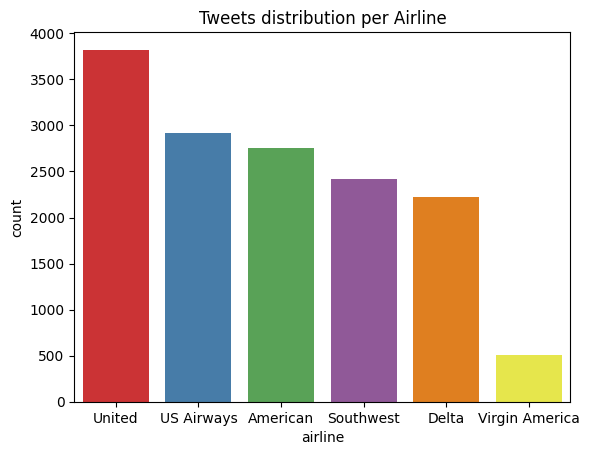

In [ ]:

ax = sns.countplot(x="airline", data=df, order=df['airline'].value_counts().index, palette='Set1')
plt.title('Tweets distribution per Airline')
plt.show()


The graph shows the distribution of tweets across different airlines.
United Airlines has the highest number of tweets, followed by American Airlines.
This indicates that these airlines might be more visible or have a larger customer base on Twitter, leading to more tweets about their services.
It's important to note that this doesn't necessarily reflect the overall sentiment towards each airline.

<ipython-input-25-9cca81ee8366>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='negativereason', data=df, order=df['negativereason'].value_counts().index, palette='viridis')


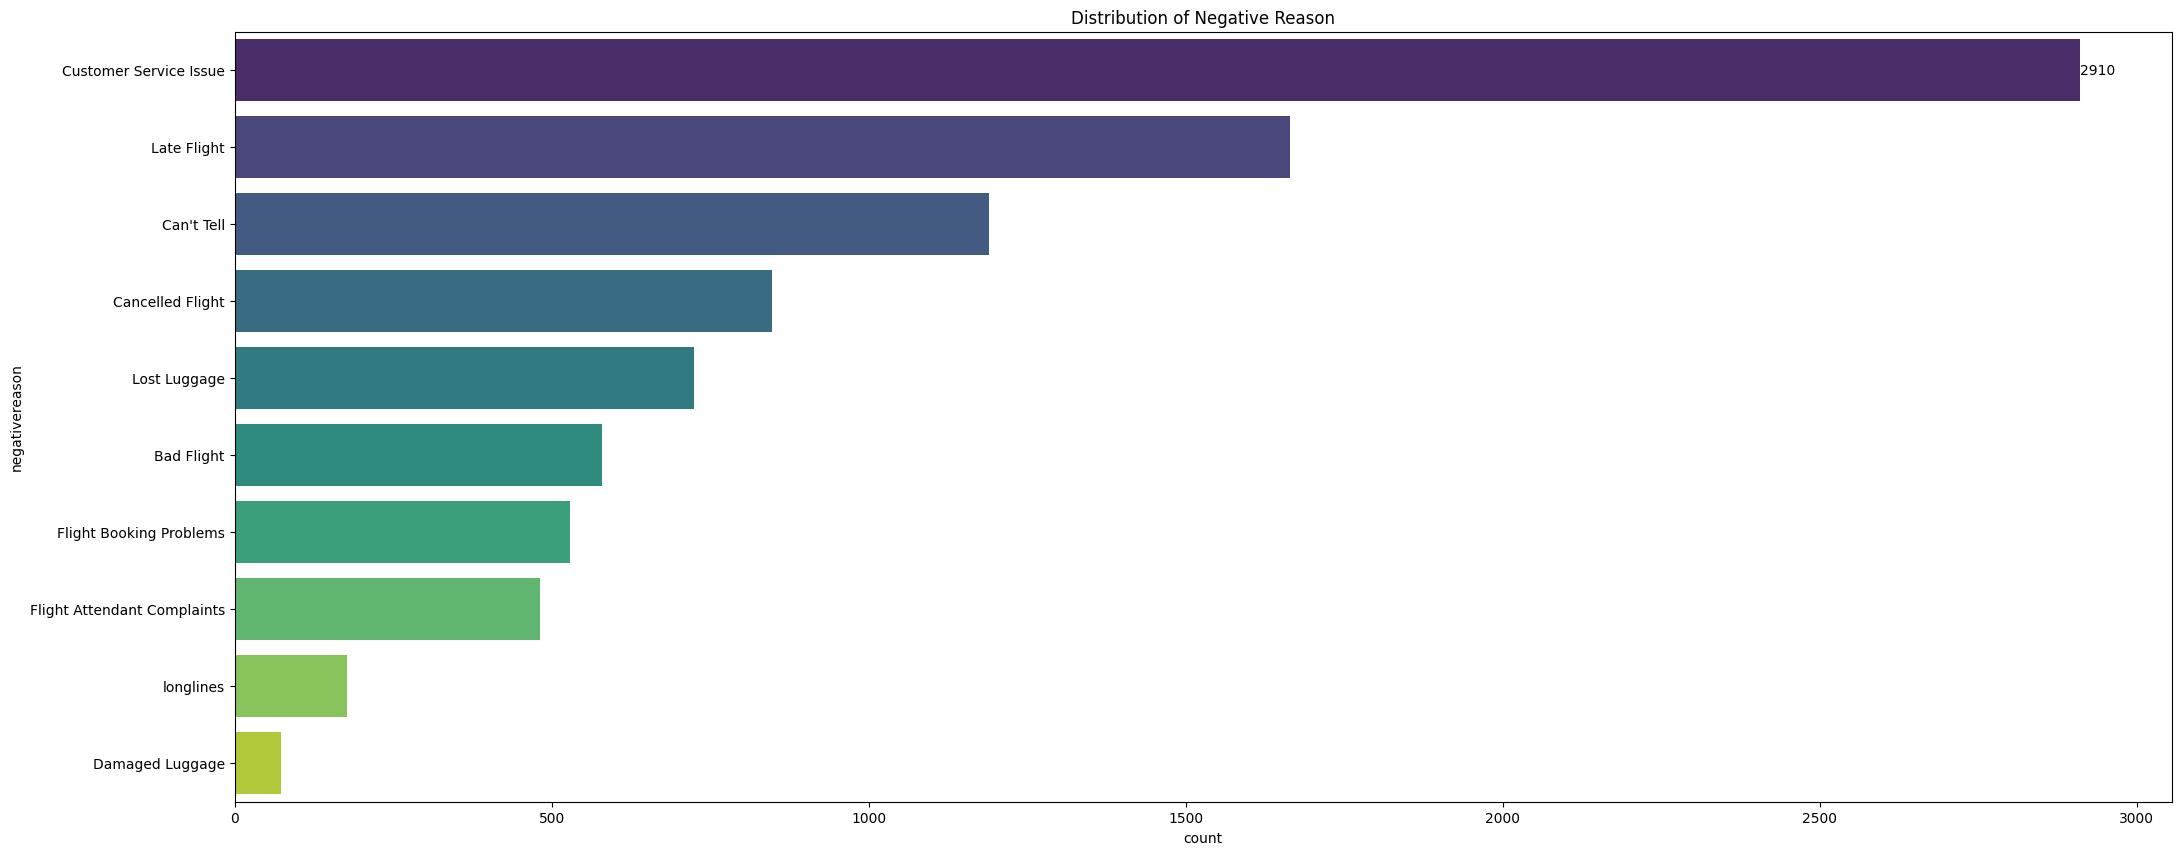

In [ ]:

plt.figure(figsize=(25,10))
ax = sns.countplot(y='negativereason', data=df, order=df['negativereason'].value_counts().index, palette='viridis')
ax.bar_label(ax.containers[0])
ax.set_title('Distribution of Negative Reason')
plt.show()


-> The graph shows the distribution of negative reasons for tweets.

-> "Customer service issue" is the most common negative reason, followed by "Late Flight" and "Bad service".

-> This information can be valuable for airlines to focus on improving their customer service processes.

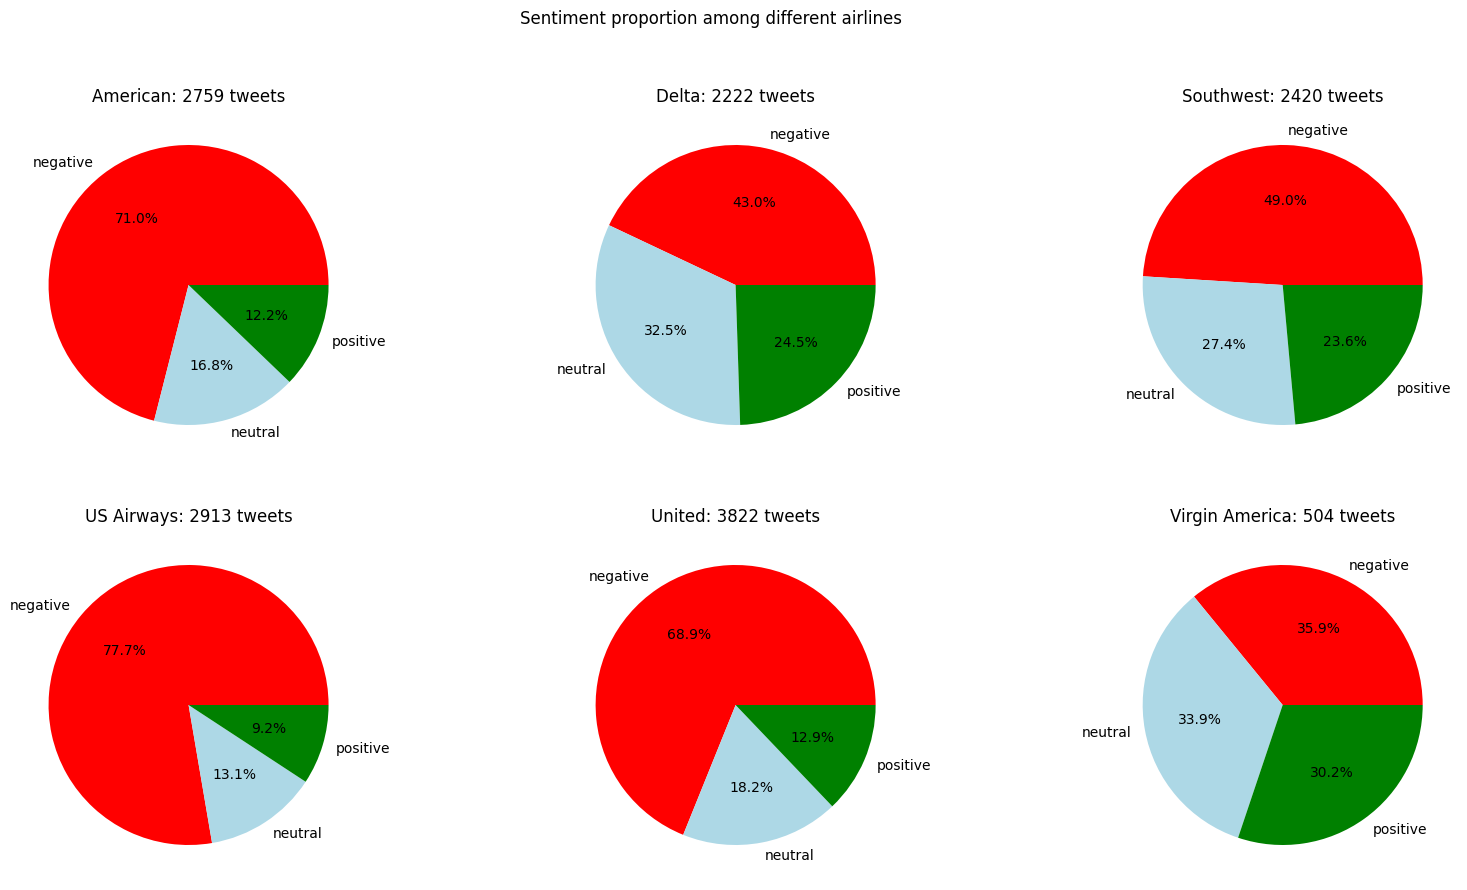

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = df.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

# Define colors for sentiments
colors = {'negative': 'red', 'neutral': 'lightblue', 'positive': 'green'}

for i, ax in zip(range(len(df['airline'].unique())), axes):
    # Extract data for the current airline
    airline_data = data.iloc[i]

    # Create a list of colors based on sentiment
    pie_colors = [colors[sentiment] for sentiment in airline_data.index]

    ax.pie(airline_data, labels=airline_data.index, autopct='%1.1f%%', colors=pie_colors)
    ax.set_title(f"{data.index[i]}: {data.values[i].sum()} tweets")

plt.suptitle('Sentiment proportion among different airlines')
plt.show()

-> American Airlines:
The high negative sentiment (75.4%) suggests potential issues with customer service, flight delays, or other operational problems.

-> Delta Airlines:(BETTER)
The balanced sentiment distribution with a high neutral percentage could indicate that while there are issues, they might not be severe enough to cause strong negative reactions.

-> Southwest Airlines:
With 60.8% negative sentiment, there are clear areas for improvement, but the relatively higher positive sentiment (11.8%) shows some customers are satisfied.

-> US Airways:
The highest negative sentiment (76.9%) indicates significant dissatisfaction, possibly due to frequent issues or poor customer service.




<ipython-input-27-15cf5410160f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df[df.airline==i]['negativereason'], order=df[df.airline==i]['negativereason'].value_counts().index, ax=ax, palette='hls')
<ipython-input-27-15cf5410160f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df[df.airline==i]['negativereason'], order=df[df.airline==i]['negativereason'].value_counts().index, ax=ax, palette='hls')
<ipython-input-27-15cf5410160f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df[df.airline==i]['negativereason'], order=df[df.air

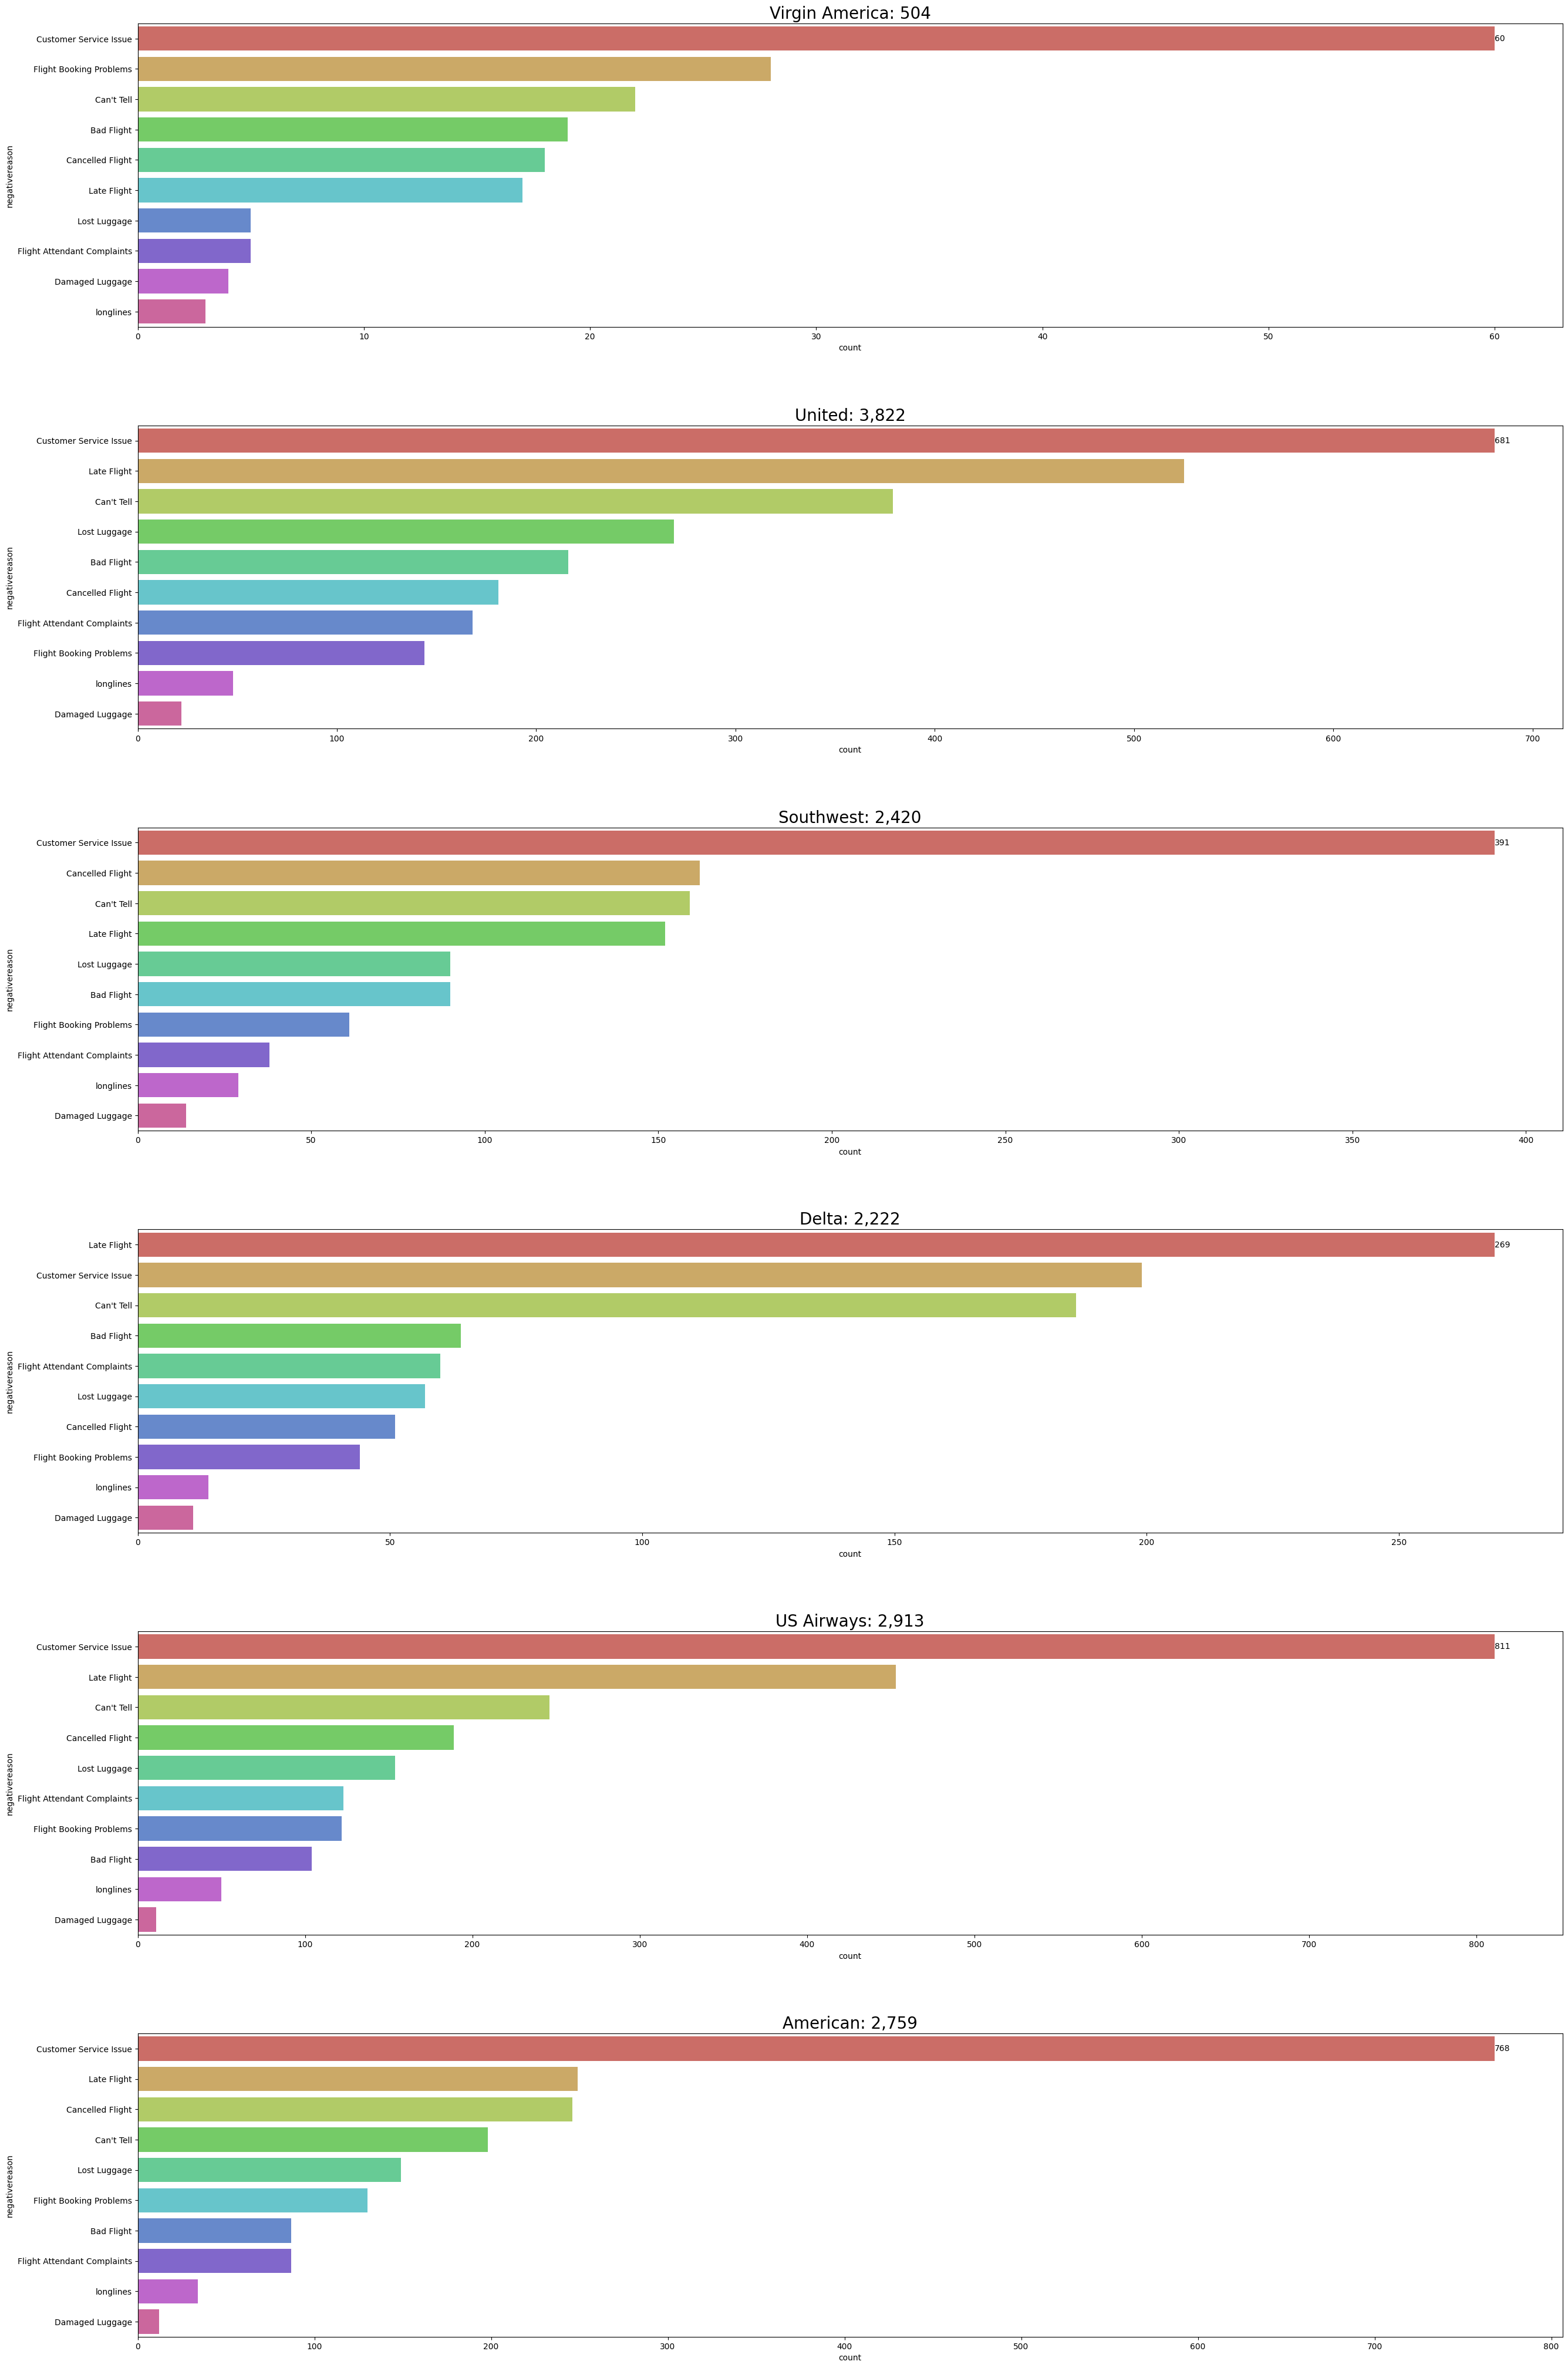

In [ ]:
# prompt: with the same below given code , some other colour

fig, axes = plt.subplots(6,1, figsize=(25,40))
fig.tight_layout(h_pad=10)
axes = axes.flatten()
for i, ax in zip(df.airline.unique(), axes):
    sns.countplot(df[df.airline==i]['negativereason'], order=df[df.airline==i]['negativereason'].value_counts().index, ax=ax, palette='hls')
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{i}: {format(len(df[df.airline==i]),',')}", fontsize=20)
plt.show()


->  Customer service issues: This appears to be the most common negative reason across all airlines. This suggests that airlines need to prioritize improving customer service interactions, including handling complaints, resolving issues, and providing helpful support.

-> Flight delays: Late flights are a significant concern for many passengers. Airlines should focus on improving flight punctuality and providing clear communication to passengers about delays.

-> Bad service:  This encompasses a range of issues, including poor in-flight service, uncomfortable seating, and inadequate amenities. Airlines should focus on improving the overall travel experience to enhance customer satisfaction.


<ipython-input-28-4dba4a786334>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-28-4dba4a786334>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-28-4dba4a786334>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-28-4dba4a786334>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-28-4dba4a786334>:11: FutureWarning: 

Pas

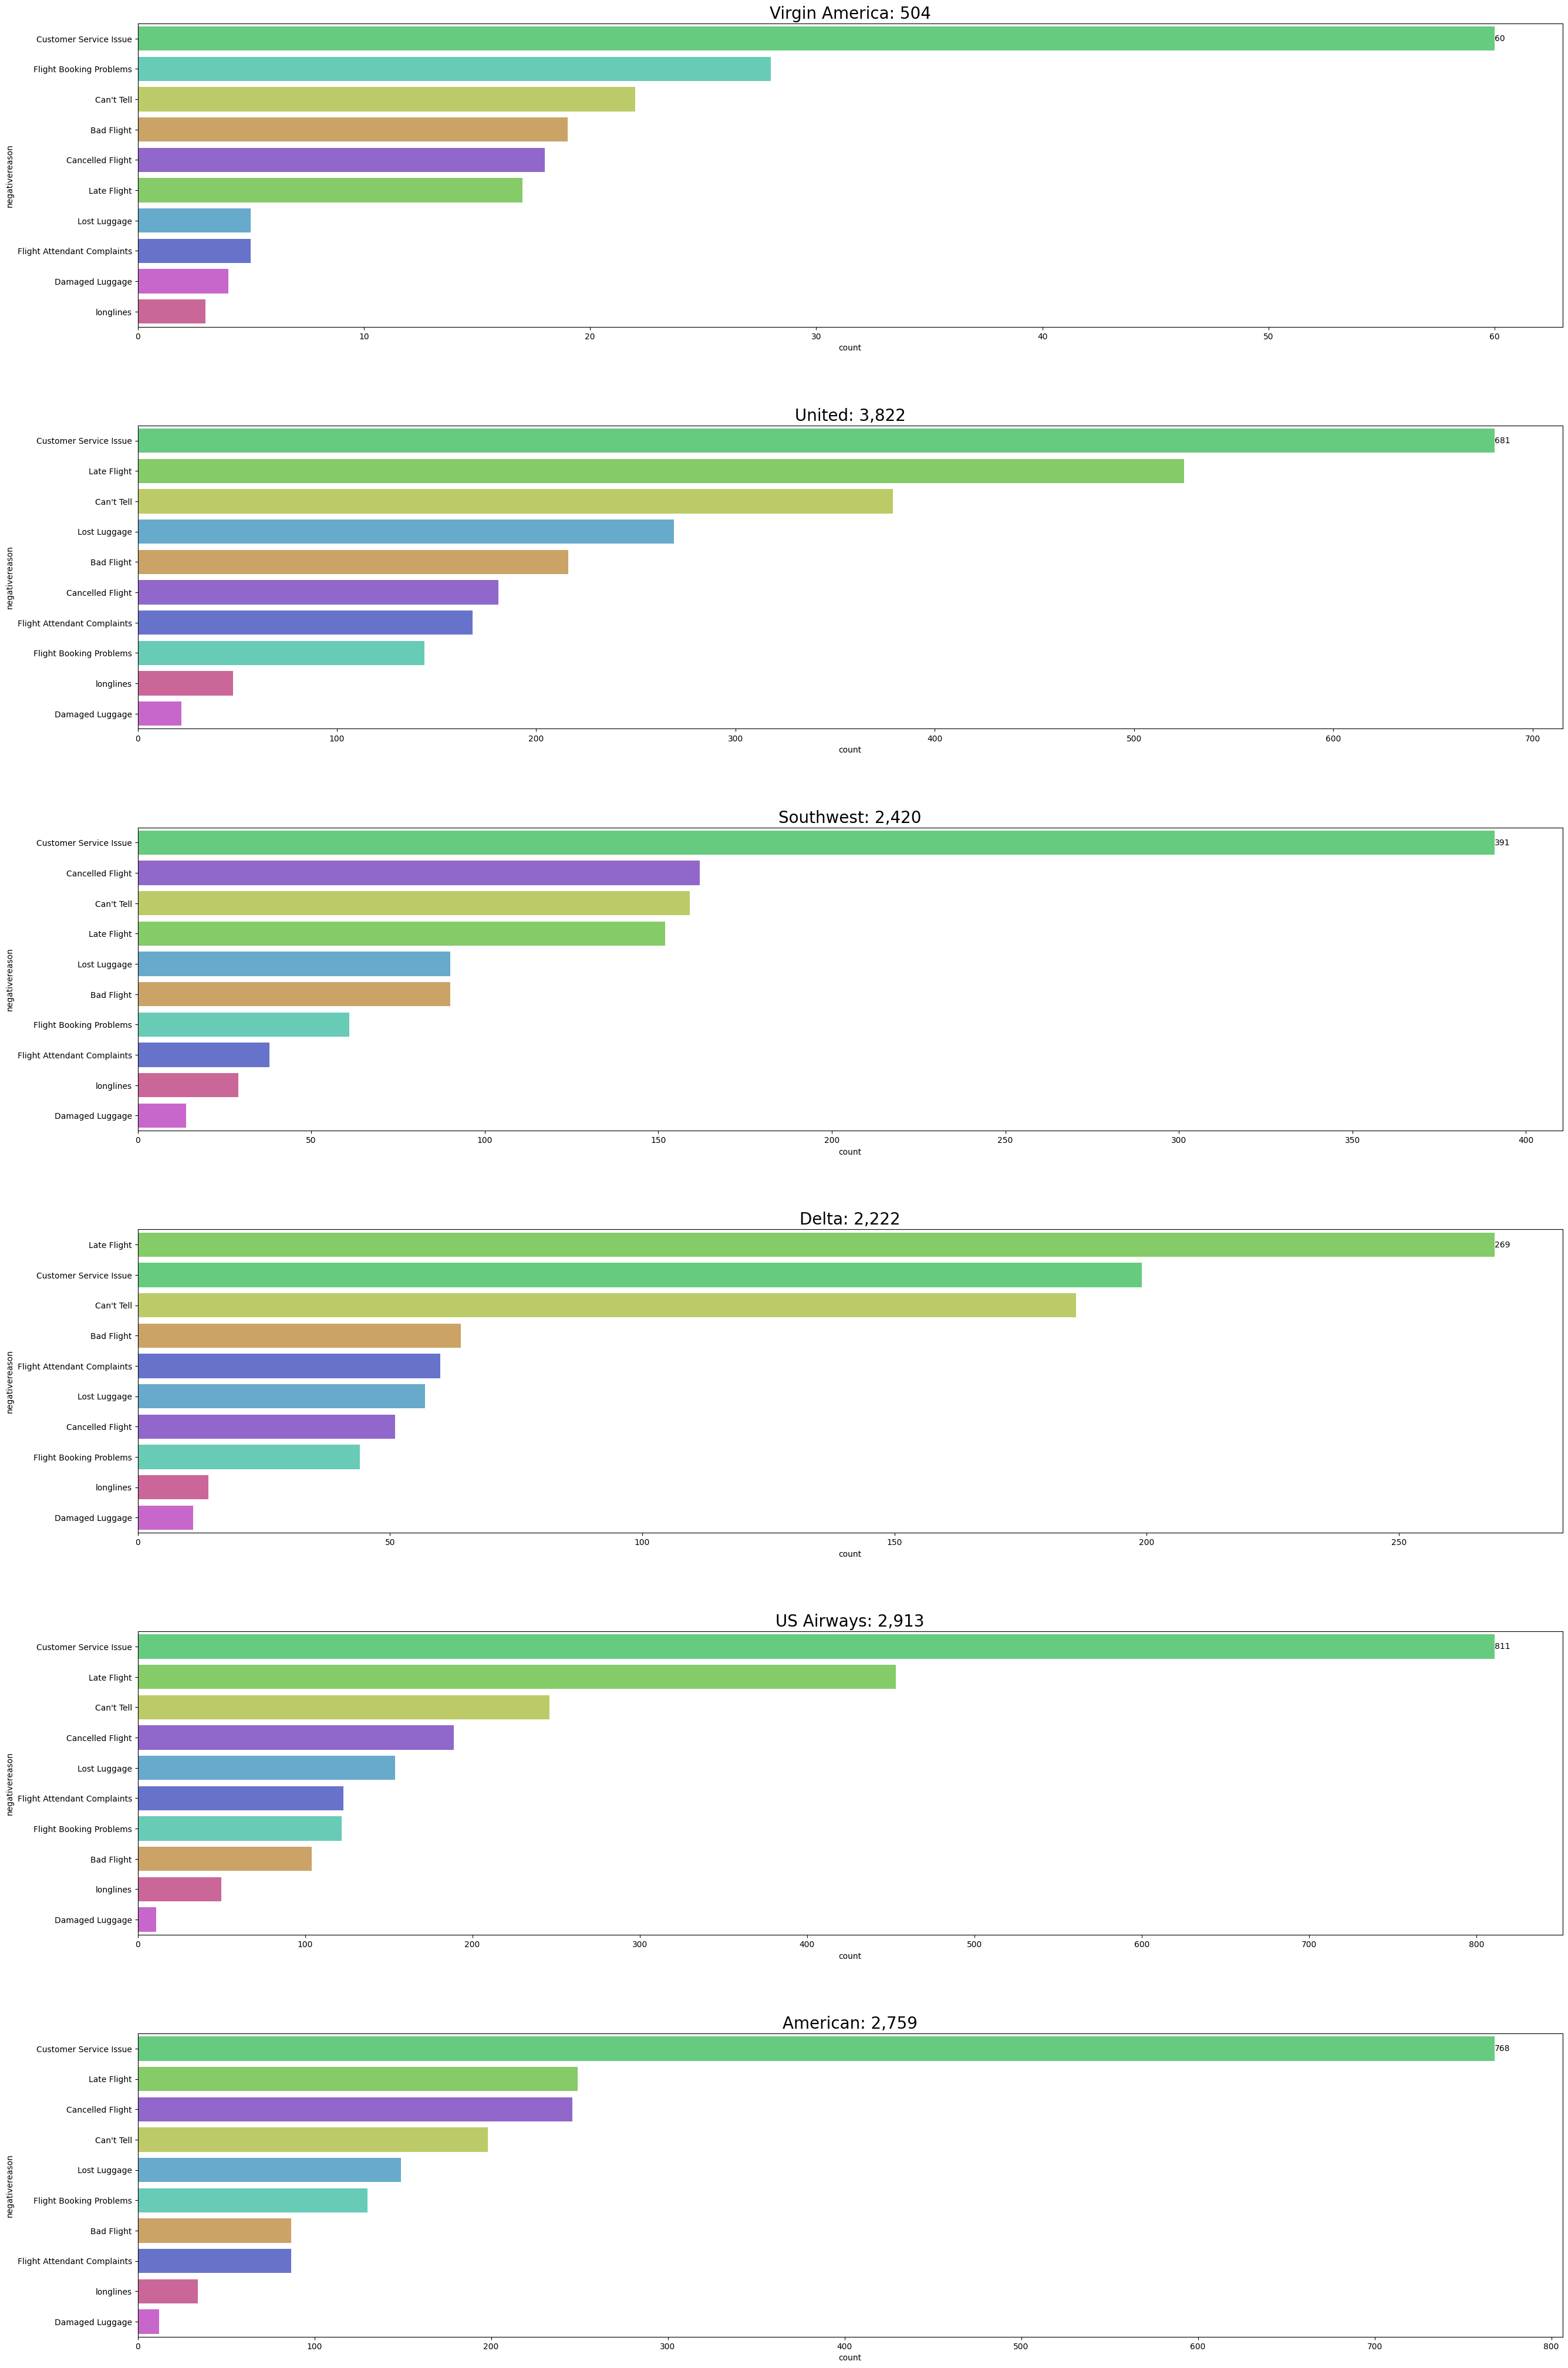

In [ ]:


import matplotlib.pyplot as plt
# Define a consistent color palette for negative reasons
palette = sns.color_palette("hls", len(df['negativereason'].unique()))
negativereason_colors = {reason: color for reason, color in zip(df['negativereason'].unique(), palette)}

fig, axes = plt.subplots(6,1, figsize=(25,40))
fig.tight_layout(h_pad=10)
axes = axes.flatten()

for i, ax in zip(df.airline.unique(), axes):
    sns.countplot(
        df[df.airline==i]['negativereason'],
        order=df[df.airline==i]['negativereason'].value_counts().index,
        ax=ax,
        palette=negativereason_colors
    )
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{i}: {format(len(df[df.airline==i]),',')}", fontsize=20)
plt.show()



In [ ]:
sentiments = df['airline_sentiment'].unique()
#here we know there are 3 types only
sentiments

array(['neutral', 'positive', 'negative'], dtype=object)

<Axes: xlabel='airline_sentiment', ylabel='count'>

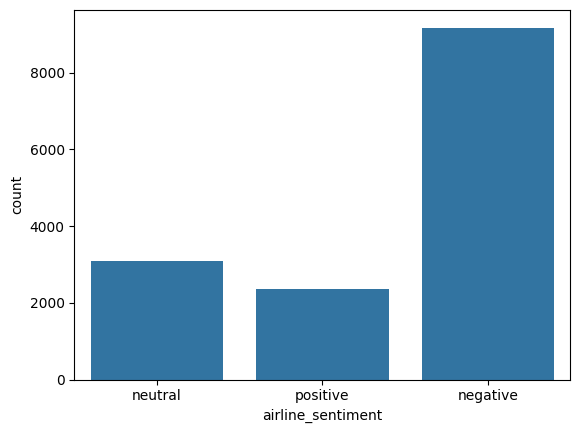

In [ ]:
sns.countplot(x=df.airline_sentiment)

Here, we can clearly see that these tweets are overwhelmingly negative.



In [ ]:
airlines = df['airline'].unique()
airlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [ ]:
airline_sentiment_counts = df.groupby(['airline', 'airline_sentiment']).size().unstack(fill_value=0)
print(airline_sentiment_counts)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


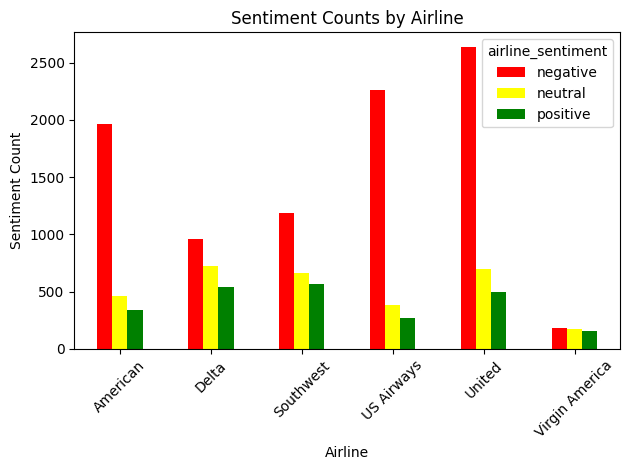

In [ ]:
airline_sentiment_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.xlabel('Airline')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Counts by Airline')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Positive word cloud**

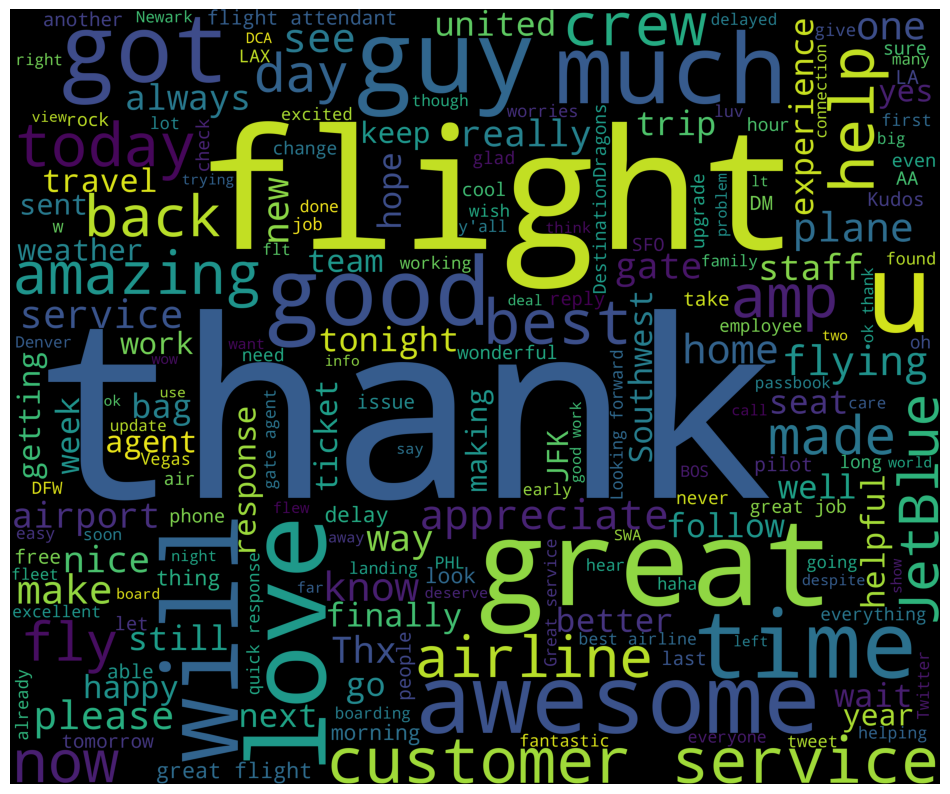

In [ ]:
from wordcloud import WordCloud, STOPWORDS
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# **Negative word cloud**

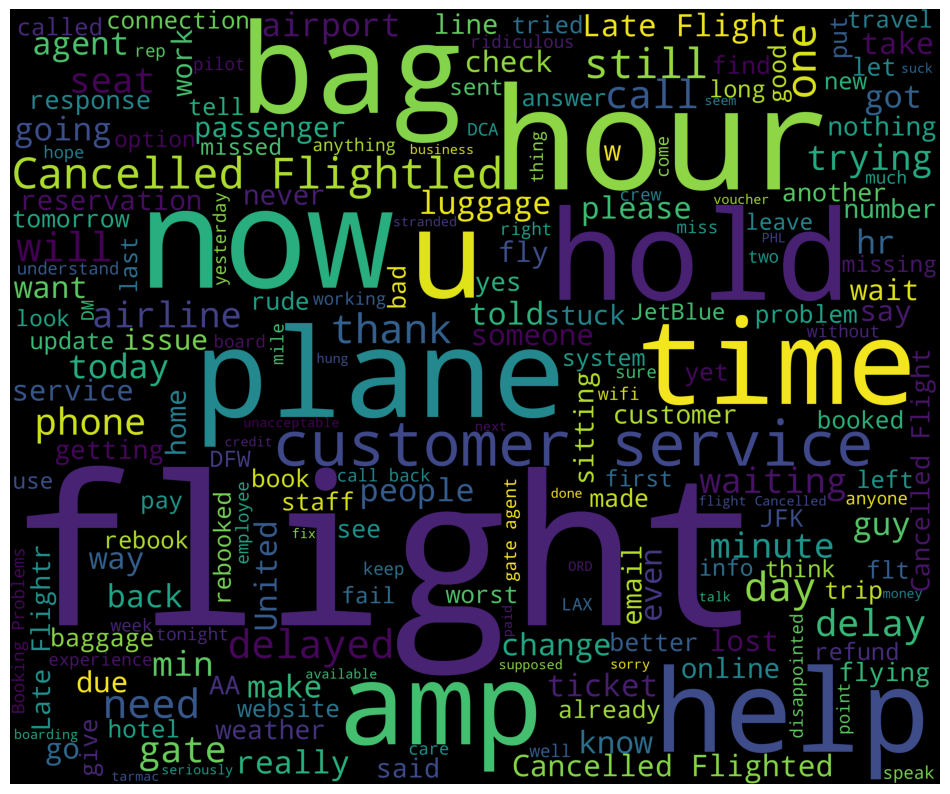

In [ ]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# **DATA PREPROCESSING**

In [ ]:
import re
def pre_processing(df):
    df['text'] = df['text'].apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', x))
    df['text'] = df['text'].apply(lambda x: re.sub('(@[A-Za-z0-9_]+)','', x))
    df['text'] = df['text'].str.strip()
    df['text'] = df['text'].str.lower()



import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['tokens'] = df['text'].apply(word_tokenize)



from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])




from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])





from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Light cleanup before tokenization
pre_processing(df)

# Encode labels
possible_labels = df.airline_sentiment.unique()
labels_map = {possible_labels[idx]: idx for idx, label in enumerate(possible_labels)}
df['labels'] = df.airline_sentiment.replace(labels_map)
print(df['labels'])

0        0
1        1
2        0
3        2
4        2
        ..
14635    1
14636    2
14637    0
14638    2
14639    0
Name: labels, Length: 14640, dtype: int64


# **UPSAMPLING**



In [ ]:
# Set color palette for plots
color = lambda: random.randint(0, 255)
colors = ['#%02X%02X%02X' %(color(), color(), color()) for i in range(6)]
sns.set_palette(sns.color_palette(colors))
rcParams['figure.figsize'] = 12, 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Check if cuda is enabled in the device
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


<Axes: xlabel='airline_sentiment', ylabel='count'>

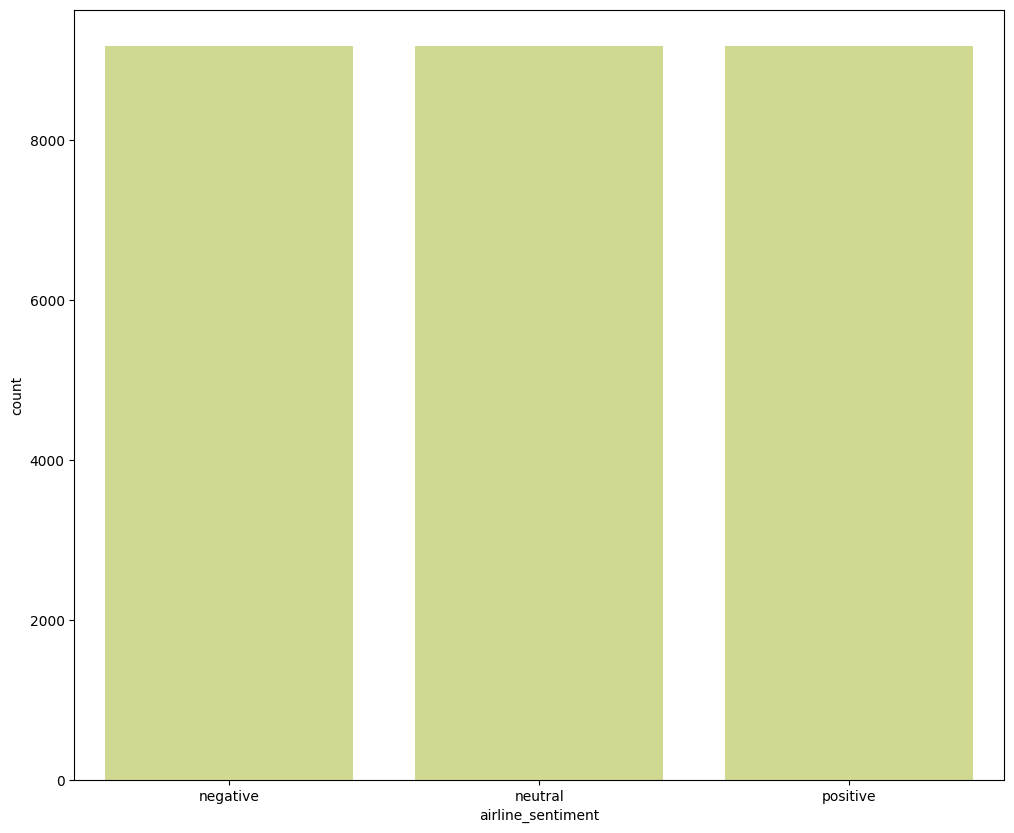

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.airline_sentiment=="negative"]
df_minority_neutral = df[df.airline_sentiment=="neutral"]
df_minority_positive = df[df.airline_sentiment=="positive"]

# Upsample minority classes
df_minority_neutral_upsampled = resample(df_minority_neutral,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=RANDOM_STATE)  # reproducible results

df_minority_positive_upsampled = resample(df_minority_positive,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=RANDOM_STATE)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_neutral_upsampled, df_minority_positive_upsampled])

# Display new class counts
df_upsampled.airline_sentiment.value_counts()
sns.countplot(x=df_upsampled.airline_sentiment)


In [ ]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

nltk.download('stopwords')
df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x = df.clean_tweet
y = df.airline_sentiment

print(len(x), len(y))

14640 14640


FEATURE ENGINEERING

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])


LABEL ENCODER

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['airline_sentiment'] = label_encoder.fit_transform(df['airline_sentiment'])


# **LOGISTIC REGRESSION**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

class_weights = compute_class_weight('balanced', classes=df['airline_sentiment'].unique(), y=df['airline_sentiment'])
model = LogisticRegression(class_weight=dict(enumerate(class_weights)))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['airline_sentiment'], test_size=0.3, random_state=42)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.802367941712204
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      2814
           1       0.68      0.52      0.59       884
           2       0.85      0.59      0.70       694

    accuracy                           0.80      4392
   macro avg       0.78      0.68      0.72      4392
weighted avg       0.80      0.80      0.79      4392



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Example new tweets
new_tweets = [" I didn't today... Must mean I need to take an...","I love flying with Virgin America!"]

# Preprocess new tweets (ensure the same preprocessing steps are applied)
new_tweets_clean = [tweet.lower().replace(r'http\S+|www\S+|https\S+', '').replace(r'[^\w\s]', '').strip() for tweet in new_tweets]

# Convert new tweets to feature vectors
new_tweets_vectorized = vectorizer.transform(new_tweets_clean)

# Predict sentiment
predictions = model.predict(new_tweets_vectorized)

print("Predictions:", predictions)


Predictions: [0 2]


In [ ]:
# Convert predictions back to original sentiment labels
predicted_labels = label_encoder.inverse_transform(predictions)
print("Predicted Sentiments:", predicted_labels)


Predicted Sentiments: ['negative' 'positive']


# **SVM**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['airline_sentiment'], test_size=0.3, random_state=42)

# Initialize the SVM model
model = SVC(kernel='linear')  # You can use 'linear', 'rbf', etc., depending on your data

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8041894353369763
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.88      2814
           1       0.66      0.55      0.60       884
           2       0.82      0.65      0.73       694

    accuracy                           0.80      4392
   macro avg       0.77      0.71      0.73      4392
weighted avg       0.80      0.80      0.80      4392



In [ ]:
# Example new tweets
new_tweets = ["I didn't today... Must mean I need to take an...	", "The flight was delayed and I missed my connection."]

# Preprocess new tweets
new_tweets_clean = [tweet.lower().replace(r'http\S+|www\S+|https\S+', '').replace(r'[^\w\s]', '').strip() for tweet in new_tweets]

# Convert new tweets to feature vectors
new_tweets_vectorized = vectorizer.transform(new_tweets_clean)

# Predict sentiment
predictions = model.predict(new_tweets_vectorized)

# Convert numerical predictions back to original sentiment labels
predicted_labels = label_encoder.inverse_transform(predictions)
print("Predicted Sentiments:", predicted_labels)


Predicted Sentiments: ['negative' 'negative']


# **FINE TUNING SVM**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
print("Accuracy with best model:", accuracy_score(y_test, y_pred_best))
print("Classification Report with best model:\n", classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score found:  0.7928374816983894
Accuracy with best model: 0.8012295081967213
Classification Report with best model:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87      2814
           1       0.67      0.53      0.59       884
           2       0.82      0.63      0.71       694

    accuracy                           0.80      4392
   macro avg       0.77      0.70      0.73      4392
weighted avg       0.79      0.80      0.79      4392



In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and transform the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train SVM model on resampled data
model_resampled = SVC(kernel='linear')
model_resampled.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_resampled = model_resampled.predict(X_test)
print("Accuracy with SMOTE resampling:", accuracy_score(y_test, y_pred_resampled))
print("Classification Report with SMOTE resampling:\n", classification_report(y_test, y_pred_resampled))


Accuracy with SMOTE resampling: 0.7873406193078324
Classification Report with SMOTE resampling:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      2814
           1       0.58      0.65      0.61       884
           2       0.73      0.71      0.72       694

    accuracy                           0.79      4392
   macro avg       0.73      0.74      0.73      4392
weighted avg       0.79      0.79      0.79      4392



In [ ]:
from sklearn.svm import SVC

# Initialize SVM with class weights
model_weighted = SVC(kernel='linear', class_weight='balanced')
model_weighted.fit(X_train, y_train)

# Make predictions
y_pred_weighted = model_weighted.predict(X_test)
print("Accuracy with class weights:", accuracy_score(y_test, y_pred_weighted))
print("Classification Report with class weights:\n", classification_report(y_test, y_pred_weighted))


Accuracy with class weights: 0.7784608378870674
Classification Report with class weights:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      2814
           1       0.56      0.68      0.61       884
           2       0.70      0.74      0.72       694

    accuracy                           0.78      4392
   macro avg       0.72      0.75      0.73      4392
weighted avg       0.80      0.78      0.78      4392



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(df['text'])

# Train-test split
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, df['airline_sentiment'], test_size=0.3, random_state=42)

# Train SVM model
model_count = SVC(kernel='linear')
model_count.fit(X_train_count, y_train)

# Make predictions
y_pred_count = model_count.predict(X_test_count)
print("Accuracy with CountVectorizer:", accuracy_score(y_test, y_pred_count))
print("Classification Report with CountVectorizer:\n", classification_report(y_test, y_pred_count))


Accuracy with CountVectorizer: 0.7807377049180327
Classification Report with CountVectorizer:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2814
           1       0.58      0.59      0.58       884
           2       0.73      0.70      0.72       694

    accuracy                           0.78      4392
   macro avg       0.72      0.72      0.72      4392
weighted avg       0.78      0.78      0.78      4392



In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

# Sample a smaller subset of the dataset for faster processing
df_sample = df.sample(n=1000, random_state=42)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)  # Limit the number of features
X = vectorizer.fit_transform(df_sample['text'])
y = df_sample['airline_sentiment']

# Initialize SVM model
model_cv = SVC(kernel='linear')

# Perform cross-validation
cv_scores = cross_val_score(model_cv, X, y, cv=5, n_jobs=-1)

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())


Cross-Validation Scores: [0.71  0.685 0.685 0.725 0.685]
Mean Cross-Validation Score: 0.6980000000000001


# **RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV


In [ ]:
# Assuming df_sample is already defined as before
X = vectorizer.fit_transform(df_sample['text'])
y = df_sample['airline_sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy with Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Classification Report with Random Forest:\n", classification_report(y_test, y_pred_rf))


Accuracy with Random Forest: 0.67
Classification Report with Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79       186
           1       0.62      0.12      0.20        67
           2       0.68      0.28      0.39        47

    accuracy                           0.67       300
   macro avg       0.66      0.45      0.46       300
weighted avg       0.66      0.67      0.60       300



In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Use the best model
best_rf_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred_best_rf = best_rf_model.predict(X_test)
print("Accuracy with tuned Random Forest:", accuracy_score(y_test, y_pred_best_rf))
print("Classification Report with tuned Random Forest:\n", classification_report(y_test, y_pred_best_rf))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
476 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best parameters found:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score:  0.6857142857142857
Accuracy with tuned Random Forest: 0.68
Classification Report with tuned Random Forest:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80       186
           1       0.59      0.19      0.29        67
           2       0.73      0.23      0.35        47

    accuracy                           0.68       300
   macro avg       0.67      0.47      0.48       300
weighted avg       0.67      0.68      0.62       300

